#### QAPP ID: I-CCED-0032994-QP-1-0
#### Author: Matthew Adams
#### Principal Investigator(s): Grace Patlewicz & Imran Shah
#### Last Modified MM DD 2022

### Notebook 001a: Single Task Learner Implementation


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('/home/madams01/march_2023/ml-tox/src')
import torch
import random
import os
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
import functools


In [10]:
DB5 = openMongo(db='genra_dev_v5',host='pb.epa.gov',auth=True)

In [11]:
def vote(x):
    votes = list(x)
    if sum(votes)/len(votes) < 0.5:
        return 0
    else:
        return 1

def get_task_data(Assay_list):
    dfs = []
    asy_list = []

    for asy in Assay_list:
        try:
            Y1 = get_bio_activities(
                                    DB5.toxcast_fp,
                                    assay=asy,
                                    fld='assay_component_name',
                                    h0='0.7',
                                    val='B1.1',
                                    full=False
                                    )
            Y = Y1.groupby('dsstox_sid').agg(lambda x: vote(x)).reset_index()
            if Y.shape[0] > 0:
                dfs.append(Y)
                asy_list.append(asy)
        except:
            pass
    print('loop done')
    df_final = functools.reduce(lambda left,right: pd.merge(left,right,on='dsstox_sid',how='outer'), dfs).fillna(-1)

    cols = [asy for asy in asy_list]
    cols.insert(0,'dsstox_sid')
    Y1 = df_final[cols]

    X1 = get_chm_FP(
                    Y1.dsstox_sid,
                    DB5.chms_fp,
                    fp='mrgn',
                    fill=np.uint(0)
                    )

    SID = set(X1.dsstox_sid.to_list()).intersection(Y1.dsstox_sid)

    XY1 = X1.merge(Y1,on='dsstox_sid',how='right')
    XY1 = XY1[XY1.dsstox_sid.isin(SID)]
    
    X = XY1[X1.columns[X1.columns!='dsstox_sid']]
    Y = XY1[Y1.columns[Y1.columns!='dsstox_sid']]

    return X,Y


In [12]:
Assay_list = 'ATG'

if os.path.exists(f'db_datasets/{Assay_list}_x_with_dtx.pkl') and os.path.exists(f'db_datasets/{Assay_list}_y_with_dtx.pkl'):
    X = pd.read_pickle(f'db_datasets/{Assay_list}_x_with_dtx.pkl').iloc[:,1:-1]
    Y = pd.read_pickle(f'db_datasets/{Assay_list}_y_with_dtx.pkl').iloc[:,1:]
    
else:
    Assay_list = get_bio_assays(DB5.toxcast_assays)
    prefixes = set([i.split('_')[0] for i in Assay_list])
    ATG_assays = [i for i in Assay_list if i.startswith('ATG_')]
    X,Y = get_task_data(ATG_assays)


## Filter/Impute missing Assay label values

In [13]:
random.seed(42)
def assign_missing_values(X,counts):
    p_hit = counts[1] /(counts[0] + counts[1])
    p_nohit = 1 - p_hit
    if X == -1:
         X = random.choices((1,0),weights=[p_hit,p_nohit],k=1)[0]
    return X

def replace_missing_data(y,mode):
    y_new = y.loc[:, ~(y== -1.0).sum()>-y.shape[0]*0.1]   #drop columns with > 10% missing data
    if mode == 'impute':
        for column in y_new:
            if (y_new[column]==-1).any() and not (y_new[column]==-1).all():
                counts = y_new[column].value_counts()
                y_new[column] = y_new[column].apply(lambda x: assign_missing_values(x,counts))
    elif mode == 'fill':
        y_new = y_new.replace(-1,0)
    elif mode == None:
        pass
    return y_new.apply(np.int64)


In [14]:
Y_new = replace_missing_data(Y,'fill')

## Load Unlabeled Dataset

In [15]:
import deepchem as dc

tsca_data = pd.read_excel('NCCRP_picklist_round2_refchem_reps.xlsx',sheet_name='Main Data')

unlabeled_data = get_chm_FP(
                tsca_data.DTXSID,
                DB5.chms_fp,
                fp='mrgn',
                fill=np.uint(0)
                    )

N_unlabeled = unlabeled_data.shape[0]

unlabeled_fp = unlabeled_data.iloc[:,1:]

unlabeled_X = pd.concat([X,unlabeled_fp]).fillna(0).tail(N_unlabeled)

dummy_labels = np.zeros((N_unlabeled,1))

unlabeled_dataset = dc.data.NumpyDataset(X=unlabeled_X, y=dummy_labels)

n_features = unlabeled_X.shape[1]

print("Number of chemicals in dataset:", N_unlabeled)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/madams01/anaconda3/envs/matt_env/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Number of chemicals in dataset: 342


In [16]:
from rdkit.Chem import PandasTools
TSCA_dtx = PandasTools.LoadSDF('TSCA_JUL22_v3_QSAR-ready_kek.sdf')[['ID']].rename(columns={'ID':'DTXSID'})

In [17]:
TSCA_dtx

,DTXSID
0,DTXSID3060164
1,DTXSID7060837
2,DTXSID9025879
3,DTXSID2026282
4,DTXSID4052188
...,...
13294,DTXSID5064209
13295,DTXSID7062873
13296,DTXSID9040342
13297,DTXSID3044889


In [18]:
unlabeled_data = get_chm_FP(
                TSCA_dtx.DTXSID,
                DB5.chms_fp,
                fp='mrgn',
                fill=np.uint(0)
                    )

N_unlabeled = unlabeled_data.shape[0]

unlabeled_fp = unlabeled_data.iloc[:,1:]

unlabeled_X = pd.concat([X,unlabeled_fp]).fillna(0).tail(N_unlabeled)

dummy_labels = np.zeros((N_unlabeled,1))

unlabeled_dataset = dc.data.NumpyDataset(X=unlabeled_X, y=dummy_labels)

n_features = unlabeled_X.shape[1]

print("Number of chemicals in dataset:", N_unlabeled)

Number of chemicals in dataset: 13212


In [19]:
unlabeled_dataset

<NumpyDataset X.shape: (13212, 2048), y.shape: (13212, 1), w.shape: (13212, 1), task_names: [0]>

## Configure Models

In [20]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from genra.rax.skl.cls import *

gen_model =  dc.models.SklearnModel(GenRAPredClass(n_neighbors=10,metric='jaccard'))
rf_model =  dc.models.SklearnModel(RandomForestClassifier())
lr_model =  dc.models.SklearnModel(LogisticRegression(max_iter=300,n_jobs=-1))
gb_model =  dc.models.SklearnModel(GradientBoostingClassifier())
single_task_model = dc.models.MultitaskClassifier(1, n_features,layer_sizes=[500],model_dir=f'{os.getcwd()}/tmp_mtl_model/')

models = [("GenRA",gen_model),
          ('Random Forest',rf_model),
          ('Logistic Regression',lr_model),
          ('Gradient Boosting',gb_model),
          ('Single Task NN',single_task_model)
          ]

models = [("GenRA",gen_model),('Logistic Regression',lr_model),]

In [21]:
Y_new.columns

Index(['ATG_AP_1_CIS', 'ATG_AP_2_CIS', 'ATG_AR_TRANS', 'ATG_Ahr_CIS',
       'ATG_BRE_CIS', 'ATG_CAR_TRANS', 'ATG_CMV_CIS', 'ATG_CRE_CIS',
       'ATG_C_EBP_CIS', 'ATG_DR4_LXR_CIS', 'ATG_DR5_RAR_CIS', 'ATG_E2F_CIS',
       'ATG_EGR_CIS', 'ATG_ERE_CIS', 'ATG_ERRa_TRANS', 'ATG_ERRg_TRANS',
       'ATG_ERa_TRANS', 'ATG_E_Box_CIS', 'ATG_Ets_CIS', 'ATG_FXR_TRANS',
       'ATG_FoxA2_CIS', 'ATG_FoxO_CIS', 'ATG_GAL4_TRANS', 'ATG_GATA_CIS',
       'ATG_GLI_CIS', 'ATG_GRE_CIS', 'ATG_GR_TRANS', 'ATG_HIF1a_CIS',
       'ATG_HNF4a_TRANS', 'ATG_HNF6_CIS', 'ATG_HSE_CIS', 'ATG_IR1_CIS',
       'ATG_ISRE_CIS', 'ATG_LXRa_TRANS', 'ATG_LXRb_TRANS', 'ATG_MRE_CIS',
       'ATG_M_06_CIS', 'ATG_M_06_TRANS', 'ATG_M_19_CIS', 'ATG_M_19_TRANS',
       'ATG_M_32_CIS', 'ATG_M_32_TRANS', 'ATG_M_61_CIS', 'ATG_M_61_TRANS',
       'ATG_Myb_CIS', 'ATG_Myc_CIS', 'ATG_NFI_CIS', 'ATG_NF_kB_CIS',
       'ATG_NRF1_CIS', 'ATG_NRF2_ARE_CIS', 'ATG_NURR1_TRANS',
       'ATG_Oct_MLP_CIS', 'ATG_PBREM_CIS', 'ATG_PPARa_TRANS',
     

## Run Predictions


In [33]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

dfs = []
preds = pd.DataFrame()
pred_prob = pd.DataFrame()
preds['DTXSID'] = unlabeled_data.iloc[:,0]
pred_prob['DTXSID'] = unlabeled_data.iloc[:,0]


def to_one_hot(X):
    if X >= 0.5:
        return 1
    else:
        return 0

f = np.vectorize(to_one_hot)

for m in models:
    for i in range(1):
        tasks = Y_new.columns.tolist()
        N_tasks = len(tasks)
        splitter = dc.splits.RandomStratifiedSplitter()
        res = []
        Y_new = Y_new.replace(-1,0).apply(np.int64)
        for j in range(N_tasks):
            Y_in = Y_new.iloc[:,j].values.reshape((-1,1))
            dataset = dc.data.NumpyDataset(X,Y_in) 
            model = m[1]
            train_dataset, _ ,test_dataset = splitter.train_valid_test_split(dataset,
                                                                frac_train=0.8,
                                                                frac_test=0.2,
                                                                frac_valid=0.0,
                                                                seed=0,               
                                                                test_dir=f'{os.getcwd()}/tmp_test_data/',
                                                                train_dir=f'{os.getcwd()}/tmp_train_data/',
                                                                valid_dir=f'{os.getcwd()}/tmp_valid_data/')        
            model.fit(train_dataset)
            y_pred_test = model.predict(test_dataset)

            y_pred_unlabeled = model.predict(unlabeled_dataset)
            metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
            test_score = model.evaluate(test_dataset, [metric])
            res.append([tasks[j],test_score['roc_auc_score'],m[0]])
            
            if m[0] == 'Single Task NN':
                preds[m[0]] = f(y_pred_unlabeled[:,0][:,1])
                pred_prob[f'Model: {m[0]} - Assay: {tasks[j]}'] = y_pred_unlabeled[:,0][:,1]

            else:
                preds[m[0]] = f(y_pred_unlabeled[:,1])
                pred_prob[f'Model: {m[0]} - Assay: {tasks[j]}'] = y_pred_unlabeled[:,1]

            #y_pred_unlabeled[:,1] #prob. of being labeled as active.

            
        results = pd.DataFrame(res)
        dfs.append(results)
df_c = pd.concat(dfs)


/home/madams01/anaconda3/envs/matt_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/madams01/anaconda3/envs/matt_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/madams01/anaconda3/envs/matt_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/madams01/anaconda3/envs/matt_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/madams01/anaconda3/envs/matt_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Dat

In [49]:
cols = [pred_prob.columns[0]] + [c for c in pred_prob.columns if "Logistic Regression" in c]

In [50]:
pred_prob[cols]

,DTXSID,Model: Logistic Regression - Assay: ATG_AP_1_CIS,Model: Logistic Regression - Assay: ATG_AP_2_CIS,Model: Logistic Regression - Assay: ATG_AR_TRANS,Model: Logistic Regression - Assay: ATG_Ahr_CIS,Model: Logistic Regression - Assay: ATG_BRE_CIS,Model: Logistic Regression - Assay: ATG_CAR_TRANS,Model: Logistic Regression - Assay: ATG_CMV_CIS,Model: Logistic Regression - Assay: ATG_CRE_CIS,Model: Logistic Regression - Assay: ATG_C_EBP_CIS,...,Model: Logistic Regression - Assay: ATG_Sp1_CIS,Model: Logistic Regression - Assay: ATG_TAL_CIS,Model: Logistic Regression - Assay: ATG_TA_CIS,Model: Logistic Regression - Assay: ATG_TCF_b_cat_CIS,Model: Logistic Regression - Assay: ATG_TGFb_CIS,Model: Logistic Regression - Assay: ATG_THRa1_TRANS,Model: Logistic Regression - Assay: ATG_VDRE_CIS,Model: Logistic Regression - Assay: ATG_VDR_TRANS,Model: Logistic Regression - Assay: ATG_Xbp1_CIS,Model: Logistic Regression - Assay: ATG_p53_CIS
0,DTXSID001004378,0.729383,0.216517,0.010015,0.694939,0.019562,0.352987,0.920077,0.135806,0.016522,...,0.269133,0.006531,0.072053,0.020754,0.629868,0.025311,0.822518,0.004607,0.306757,0.222699
1,DTXSID001007489,0.380495,0.991854,0.067959,0.260244,0.036772,0.876604,0.121077,0.061568,0.221695,...,0.601578,0.027893,0.959296,0.922153,0.049336,0.020885,0.991962,0.053928,0.971810,0.999713
2,DTXSID001014412,0.134779,0.329108,0.010842,0.111827,0.573202,0.076834,0.755804,0.634991,0.104123,...,0.041237,0.008385,0.015154,0.005710,0.742936,0.008548,0.035449,0.063237,0.015991,0.526410
3,DTXSID001014612,0.899529,0.131058,0.620256,0.923830,0.043028,0.200587,0.992349,0.943945,0.996814,...,0.044880,0.616903,0.538656,0.794209,0.287613,0.000452,0.512297,0.975781,0.675489,0.958556
4,DTXSID001014636,0.029443,0.474638,0.030224,0.218239,0.162454,0.104055,0.093337,0.206834,0.042650,...,0.008324,0.004871,0.018610,0.068646,0.089823,0.191187,0.167560,0.429046,0.037409,0.011043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13207,DTXSID90979094,0.515666,0.012073,0.004114,0.666621,0.239534,0.186320,0.065625,0.005349,0.000971,...,0.020284,0.053029,0.057864,0.176576,0.081891,0.071498,0.073789,0.029621,0.014210,0.008533
13208,DTXSID90985276,0.151529,0.278261,0.052732,0.223489,0.064007,0.027402,0.112155,0.063857,0.273152,...,0.120480,0.082914,0.061867,0.077238,0.416237,0.061281,0.316835,0.038957,0.149854,0.065856
13209,DTXSID90988262,0.588024,0.498658,0.015639,0.493129,0.450023,0.146224,0.871047,0.433963,0.770185,...,0.003347,0.734444,0.005610,0.030837,0.942131,0.020573,0.720515,0.002701,0.040259,0.001856
13210,DTXSID90988560,0.009460,0.073585,0.000964,0.572083,0.013159,0.004979,0.158166,0.038232,0.022903,...,0.220798,0.001291,0.026636,0.038787,0.014158,0.036115,0.200059,0.020312,0.008710,0.001723


## Defining the Global Applicability Domain 

Calculate Leverage

$$ H = {X(X^TX)^{-1}X^T} $$

In [51]:
train_set = train_dataset.X
print(train_set.shape)
tsca_set = unlabeled_dataset.X
print(tsca_set.shape)

(2781, 2048)
(13212, 2048)


In [52]:
def leverage(train_set,test_set):
    Ht = test_set.dot(np.linalg.inv(train_set.T.dot(train_set)).dot(test_set.T))
    hat_diag = np.diagonal(Ht)
    return hat_diag

In [53]:
hat_diag = leverage(train_set,tsca_set)
p = train_set.shape[1]
n = train_set.shape[0]

threshold = 3*(p/n)

threshold

2.209277238403452

In [54]:
pred_prob['Leverage Score'] = hat_diag

In [55]:
pred_prob.to_pickle('LogReg_ATG_TSCA_Leverage.pkl')

In [208]:
mylst = []
for i in range(len(hat_diag)):
    if hat_diag[i] > threshold:
        mylst.append(0)
    else:
        mylst.append(1)
len(mylst)

342

In [ ]:
from openTSNE import TSNE

def get_tsne(train_dataset,test_dataset):
    """
    Parameters
    ----------
    train_dataset:

    test_dataset:

    Returns
    -------
    
    train_z: np.ndarray
            Embedding of the training data in low-dimensional space.

    test_z: np.ndarray
            Embedding of the test data in low-dimensional space.

    """
    tsne = TSNE(    
        metric="euclidean",
        n_jobs=8,
        random_state=1,
        verbose=False,
    )
    train_z = tsne.fit(train_dataset.X)
    test_z = train_z.transform(test_dataset.X)
    unlabeled_z = train_z.transform(unlabeled_dataset.X)
    return train_z, test_z, unlabeled_z

import seaborn as sns

train_z, test_z, unlabeled_z = get_tsne(train_dataset,test_dataset)

df = pd.DataFrame()

df['comp-1'] = train_z[:,0]
df['comp-2'] = train_z[:,1]
df['labels'] = train_dataset.y

sns.set(rc={"figure.figsize":(10, 10)}) 
p = sns.jointplot(data=df,
              x='comp-1',
              y='comp-2',
              kind='kde',
              hue='labels',
              palette=['b','r'],
              alpha=0.5,
              levels=6,
              thresh=0.1,
              fill=True)

p.fig.suptitle(assays[0])
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

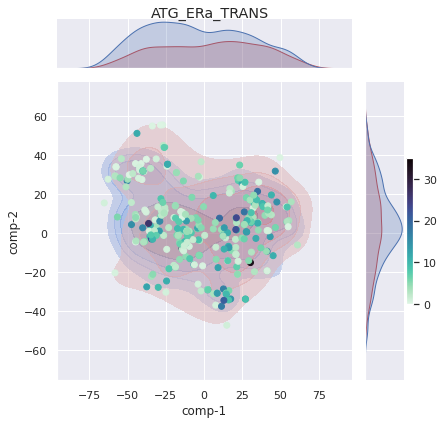

In [209]:
df = pd.DataFrame()

df['comp-1'] = train_z[:,0]
df['comp-2'] = train_z[:,1]
df['labels'] = train_dataset.y

sns.set(rc={"figure.figsize":(12, 12)})
 
p = sns.jointplot(data=df,
              x='comp-1',
              y='comp-2',
              kind='kde',
              hue='labels',
              palette=['b','r'],
              alpha=0.5,
              levels=6,
              thresh=0.1,
              legend=False,
              fill=True)

p.fig.suptitle(assays[0])
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

#########

preds['leverage'] = hat_diag
df_unlabeled = pd.DataFrame()
df_unlabeled['comp-1'] = unlabeled_z[:,0]
df_unlabeled['comp-2'] = unlabeled_z[:,1]
unlabeled_preds = preds['N_positive_preds']
unlabeled_lev = preds['leverage']


color_map = 'mako_r'

g = p.ax_joint.scatter(data=df_unlabeled,
                x='comp-1',
                y='comp-2',
                c=unlabeled_lev,
                cmap=color_map,
                vmin=0,
                vmax=35,
)
sm = plt.cm.ScalarMappable(cmap=color_map, norm=None)
sm.set_array([0,35])
g.figure.colorbar(sm)


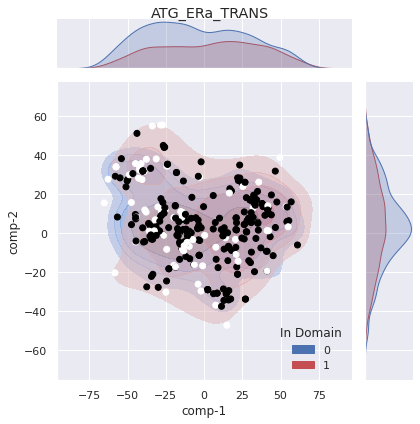

In [210]:
preds['global_domain'] = mylst

df = pd.DataFrame()

df['comp-1'] = train_z[:,0]
df['comp-2'] = train_z[:,1]
df['labels'] = train_dataset.y

sns.set(rc={"figure.figsize":(10, 10)}) 
p = sns.jointplot(data=df,
              x='comp-1',
              y='comp-2',
              kind='kde',
              hue='labels',
              palette=['b','r'],
              alpha=0.5,
              levels=6,
              thresh=0.1,
              fill=True)

p.fig.suptitle(assays[0])
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 



unlabeled_ad = preds['global_domain']

g = p.ax_joint.scatter(data=df_unlabeled,
                x='comp-1',
                y='comp-2',
                c=unlabeled_ad,
                cmap='Greys',
                vmin=0,
                vmax=1,
                label='test'
)

sns.set(rc={"figure.figsize":(9, 6)}) 

sns.move_legend(p.ax_joint, "lower right", title='In Domain', frameon=False)


In [211]:
tmp = pd.DataFrame()

tmp['unlabeled_preds'] = pred_prob['Random Forest']

tmp['Prob.'] = pd.cut(tmp['unlabeled_preds'],
        bins=[0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
        labels=['0%','1-10%','10-20%','20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-100%']).values

In [212]:
tmp['leverage'] = hat_diag
tmp['global_domain'] = mylst


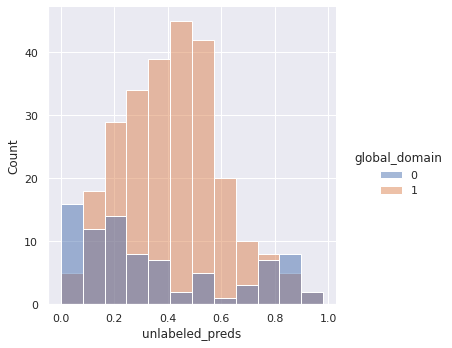

In [213]:
sns.displot(data=tmp,x='unlabeled_preds',hue='global_domain')

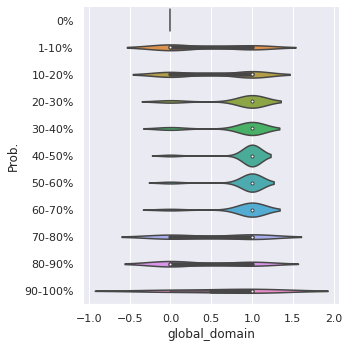

In [199]:
sns.catplot(data=tmp,x="global_domain",y='Prob.',kind='violin')